<a href="https://colab.research.google.com/github/woainio15200/DD2424-Deep-learning-in-data-science-/blob/main/%E2%80%9CAssignment1_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%ACbonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DD2424 Deep Learning - Assignment 1
Implementation of a one layer neural network for CIFAR-10 classification

In [1]:
# 导入必要的库
import numpy as np
import pickle
import matplotlib.pyplot as plt
import copy
import time
import datetime
import torch
from google.colab import drive

# 挂载Google Drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
def LoadBatch(filename):
    """加载CIFAR-10数据batch"""
    with open(filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

    X = dict[b'data'].astype(np.float64) / 255.0
    X = X.transpose()

    y = np.array(dict[b'labels'])
    Y = np.zeros((10, X.shape[1]))
    for i in range(X.shape[1]):
        Y[y[i], i] = 1

    return X, Y, y

In [49]:
def CreateValidationSet(X, Y, y, val_size=1000):
    """从训练数据中分离验证集"""
    n = X.shape[1]
    indices = np.random.permutation(n)
    return (X[:, indices[val_size:]], Y[:, indices[val_size:]], y[indices[val_size:]],
            X[:, indices[:val_size]], Y[:, indices[:val_size]], y[indices[:val_size]])


In [50]:
def ComputeLoss(P, Y):
    """计算交叉熵损失"""
    n = P.shape[1]
    L = -np.sum(Y * np.log(P)) / n
    return L

In [51]:
def ComputeAccuracy(P, y):
    """计算分类准确率"""
    pred = np.argmax(P, axis=0)
    acc = np.mean(pred == y)
    return acc

In [52]:
def ApplyNetwork(X, network):
    """执行网络的前向传播"""
    s = network['W'] @ X + network['b']
    exp_scores = np.exp(s)
    P = exp_scores / np.sum(exp_scores, axis=0)
    return P

In [53]:
def BackwardPass(X, Y, P, network, lam):
    """计算梯度"""
    n = X.shape[1]
    g = -(Y - P)
    dW = (g @ X.T) / n + 2 * lam * network['W']
    db = np.sum(g, axis=1, keepdims=True) / n
    return {'W': dW, 'b': db}

In [54]:
def MiniBatchGD(X, Y, GDparams, init_net, lam, rng=None):
    """小批量梯度下降训练"""
    trained_net = copy.deepcopy(init_net)
    n = X.shape[1]

    train_loss = []
    val_loss = []

    for epoch in range(GDparams['n_epochs']):
        if rng is not None:
            perm = rng.permutation(n)
            X = X[:, perm]
            Y = Y[:, perm]

        for j in range(n // GDparams['n_batch']):
            j_start = j * GDparams['n_batch']
            j_end = (j+1) * GDparams['n_batch']

            Xbatch = X[:, j_start:j_end]
            Ybatch = Y[:, j_start:j_end]

            P = ApplyNetwork(Xbatch, trained_net)
            grads = BackwardPass(Xbatch, Ybatch, P, trained_net, lam)

            trained_net['W'] -= GDparams['eta'] * grads['W']
            trained_net['b'] -= GDparams['eta'] * grads['b']

        # 计算当前epoch的训练损失
        P = ApplyNetwork(X, trained_net)
        cost = ComputeLoss(P, Y)
        train_loss.append(cost)

        # 计算验证集损失
        if 'val_data' in GDparams:
            valX, valY = GDparams['val_data']
            P_val = ApplyNetwork(valX, trained_net)
            val_cost = ComputeLoss(P_val, valY)
            val_loss.append(val_cost)

        print(f"Epoch {epoch+1}, Training Loss: {cost:.3f}")

    return trained_net, train_loss, val_loss

In [55]:
# 下载并解压CIFAR-10数据集
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xvf cifar-10-python.tar.gz

--2025-03-30 17:10:40--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  40.3MB/s    in 4.0s    

2025-03-30 17:10:44 (40.9 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [56]:
# 加载数据
trainX, trainY, train_y = LoadBatch('cifar-10-batches-py/data_batch_1')
valX, valY, val_y = LoadBatch('cifar-10-batches-py/data_batch_2')
testX, testY, test_y = LoadBatch('cifar-10-batches-py/test_batch')

# 数据预处理
mean_X = np.mean(trainX, axis=1).reshape(-1, 1)
std_X = np.std(trainX, axis=1).reshape(-1, 1)

trainX = (trainX - mean_X) / std_X
valX = (valX - mean_X) / std_X
testX = (testX - mean_X) / std_X

In [57]:
# 初始化网络参数
rng = np.random.default_rng(42)
d = trainX.shape[0]
K = 10

init_net = {
    'W': 0.01 * rng.standard_normal(size=(K, d)),
    'b': np.zeros((K, 1))
}

In [58]:
# 可视化权重矩阵
def visualize_weights(network, title):
    Ws = network['W'].transpose().reshape((32, 32, 3, 10), order='F')
    W_im = np.transpose(Ws, (1, 0, 2, 3))

    plt.figure(figsize=(12, 4))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        w_im = W_im[:, :, :, i]
        w_im = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))
        plt.imshow(w_im)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()




In [59]:


def run_experiment(exp_name, trainX, trainY, testX, test_y, valX, valY, init_net, params, rng):
    """
    运行完整的实验，包括训练、记录结果和可视化
    """
    print("\n" + "="*50)
    print(f"Experiment: {exp_name}")
    current_time = datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    print(f"Current Date and Time (UTC): {current_time}")
    print("Student Name: Xinle Zhang")
    print("Current User's Login: woainio15200")
    print(f"Configuration: lambda={params['lambda']}, n-epochs={params['n_epochs']}, "
          f"n-batch={params['n_batch']}, eta={params['eta']}")
    print("-"*50)

    # 训练参数
    GDparams = {
        'n_batch': params['n_batch'],
        'eta': params['eta'],
        'n_epochs': params['n_epochs'],
        'val_data': (valX, valY)
    }

    # 记录开始时间
    start_time = time.time()

    # 训练模型
    trained_net, train_loss, val_loss = MiniBatchGD(
        trainX, trainY, GDparams, init_net, params['lambda'], rng)

    # 计算训练时间
    training_time = time.time() - start_time

    # 计算测试集准确率
    test_P = ApplyNetwork(testX, trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    # 输出最佳结果
    best_epoch = np.argmin(train_loss) + 1
    best_cost = np.min(train_loss)
    print("\nTraining Results:")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Best epoch: {best_epoch}")
    print(f"Best cost: {best_cost:.5f}")
    print(f"Final test accuracy: {test_acc:.4f}")

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss ({exp_name})')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 可视化权重
    visualize_weights(trained_net, f'Weights ({exp_name})')

    return trained_net, train_loss, val_loss, test_acc


# 定义实验配置
experiments = [
    {
        'name': 'Lambda=0, Eta=0.1',
        'params': {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40, 'lambda': 0}
    }

]

In [60]:
def run_all_experiments():
    # 运行所有实验
    results = {}
    for exp in experiments:
        results[exp['name']] = run_experiment(
            exp['name'],
            trainX, trainY,
            testX, test_y,
            valX, valY,
            init_net,
            exp['params'],
            rng
        )

    # 打印总结
    print("\nExperiment Summary:")
    print("="*50)
    for exp_name, (_, _, _, test_acc) in results.items():
        print(f"{exp_name}: Test Accuracy = {test_acc*100:.2f}%")

    return results




Experiment: Lambda=0, Eta=0.1
Current Date and Time (UTC): 2025-03-30 17:10:54
Student Name: Xinle Zhang
Current User's Login: woainio15200
Configuration: lambda=0, n-epochs=40, n-batch=100, eta=0.001
--------------------------------------------------
Epoch 1, Training Loss: 1.972
Epoch 2, Training Loss: 1.893
Epoch 3, Training Loss: 1.850
Epoch 4, Training Loss: 1.821
Epoch 5, Training Loss: 1.799
Epoch 6, Training Loss: 1.782
Epoch 7, Training Loss: 1.766
Epoch 8, Training Loss: 1.757
Epoch 9, Training Loss: 1.743
Epoch 10, Training Loss: 1.733
Epoch 11, Training Loss: 1.726
Epoch 12, Training Loss: 1.719
Epoch 13, Training Loss: 1.713
Epoch 14, Training Loss: 1.704
Epoch 15, Training Loss: 1.698
Epoch 16, Training Loss: 1.693
Epoch 17, Training Loss: 1.687
Epoch 18, Training Loss: 1.683
Epoch 19, Training Loss: 1.678
Epoch 20, Training Loss: 1.673
Epoch 21, Training Loss: 1.668
Epoch 22, Training Loss: 1.665
Epoch 23, Training Loss: 1.661
Epoch 24, Training Loss: 1.658
Epoch 25, Tr

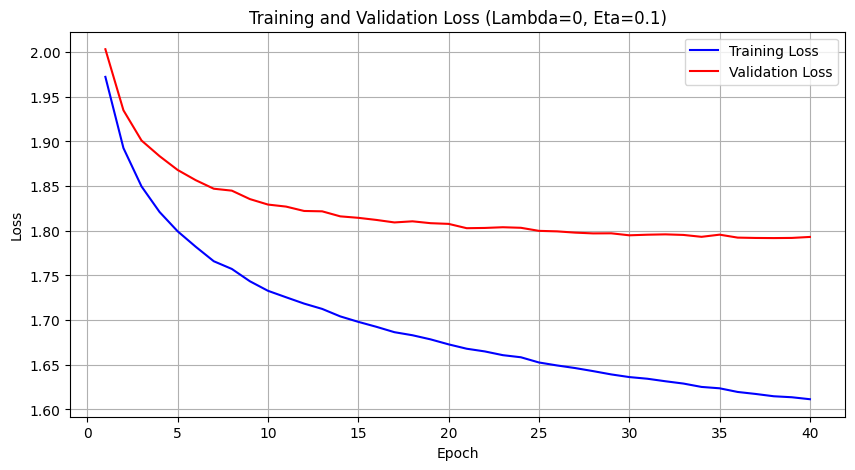

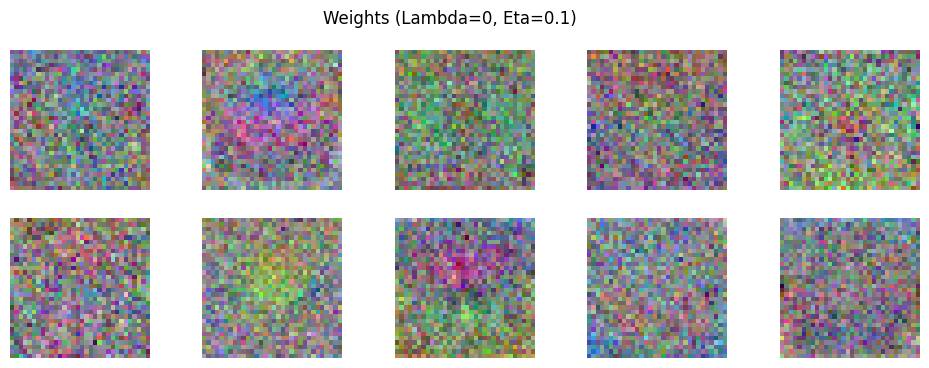


Experiment Summary:
Lambda=0, Eta=0.1: Test Accuracy = 39.14%


In [61]:
# 当您想运行实验时，调用：
results = run_all_experiments()

In [62]:
# 1. 基础模型（原始实现）
def run_baseline_experiment():
    """运行基础模型"""
    print("\nRunning Baseline Model...")

    # 使用原始的单个batch数据
    rng = np.random.default_rng(42)
    d = trainX.shape[0]
    init_net = {
        'W': 0.01 * rng.standard_normal(size=(K, d)),
        'b': np.zeros((K, 1))
    }

    GDparams = {
        'n_batch': 100,
        'eta': 0.001,
        'n_epochs': 40,
        'val_data': (valX, valY)
    }

    trained_net, train_loss, val_loss = MiniBatchGD(
        trainX, trainY, GDparams, init_net, 0.1, rng
    )

    test_P = ApplyNetwork(testX, trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    return {
        'name': 'Baseline Model',
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_acc': test_acc
    }

In [ ]:
# Load all CIFAR-10 training batches
def LoadAllTrainingData():
    """Load and combine all CIFAR-10 training batches"""
    X_all = []
    Y_all = []
    y_all = []

    for i in range(1, 6):  # CIFAR-10 has 5 training batches
        filename = f'cifar-10-batches-py/data_batch_{i}'
        X, Y, y = LoadBatch(filename)
        X_all.append(X)
        Y_all.append(Y)
        y_all.append(y)

    # Concatenate all batches
    X_combined = np.concatenate(X_all, axis=1)
    Y_combined = np.concatenate(Y_all, axis=1)
    y_combined = np.concatenate(y_all)

    return X_combined, Y_combined, y_combined

# Load and preprocess all training data
X_all, Y_all, y_all = LoadAllTrainingData()

# Set validation set size
val_size = 1000

# Split into training and validation sets
# Use last 1000 samples for validation
trainX_full = X_all[:, :-val_size]
trainY_full = Y_all[:, :-val_size]
train_y_full = y_all[:-val_size]

valX_full = X_all[:, -val_size:]
valY_full = Y_all[:, -val_size:]
val_y_full = y_all[-val_size:]

# Normalize data
mean_X_full = np.mean(trainX_full, axis=1).reshape(-1, 1)
std_X_full = np.std(trainX_full, axis=1).reshape(-1, 1)

trainX_full = (trainX_full - mean_X_full) / std_X_full
valX_full = (valX_full - mean_X_full) / std_X_full
testX = (testX - mean_X_full) / std_X_full

# Define experiments for both original and improved models
comparative_experiments = [
    {
        'name': 'Original (1 batch)',
        'params': {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40, 'lambda': 0.1},
        'data': (trainX, trainY, valX, valY, testX, test_y)
    },
    {
        'name': 'Improved (all batches)',
        'params': {'n_batch': 100, 'eta': 0.001, 'n_epochs': 40, 'lambda': 0.1},
        'data': (trainX_full, trainY_full, valX_full, valY_full, testX, test_y)
    }
]

def run_comparative_experiments():
    """Run and compare original vs improved model"""
    results = {}

    for exp in comparative_experiments:
        print(f"\nRunning {exp['name']}...")
        trainX, trainY, valX, valY, testX, test_y = exp['data']

        # Initialize network
        rng = np.random.default_rng(42)  # Use same seed for fair comparison
        d = trainX.shape[0]
        init_net = {
            'W': 0.01 * rng.standard_normal(size=(K, d)),
            'b': np.zeros((K, 1))
        }

        # Training parameters
        GDparams = {
            'n_batch': exp['params']['n_batch'],
            'eta': exp['params']['eta'],
            'n_epochs': exp['params']['n_epochs'],
            'val_data': (valX, valY)
        }

        # Train model
        trained_net, train_loss, val_loss = MiniBatchGD(
            trainX, trainY, GDparams, init_net,
            exp['params']['lambda'], rng
        )

        # Compute test accuracy
        test_P = ApplyNetwork(testX, trained_net)
        test_acc = ComputeAccuracy(test_P, test_y)

        results[exp['name']] = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'test_acc': test_acc,
            'trained_net': trained_net
        }

        print(f"Test Accuracy: {test_acc*100:.2f}%")

    return results

# Run comparison
comparative_results = run_comparative_experiments()

# Visualize comparison
plt.figure(figsize=(15, 5))

# Plot training loss
plt.subplot(121)
for exp_name, result in comparative_results.items():
    plt.plot(result['train_loss'], label=f'{exp_name} (Train)')
    plt.plot(result['val_loss'], label=f'{exp_name} (Val)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.grid(True)
plt.legend()

# Plot test accuracy comparison
plt.subplot(122)
test_accuracies = [result['test_acc'] * 100 for result in comparative_results.values()]
plt.bar(range(len(comparative_results)), test_accuracies)
plt.xticks(range(len(comparative_results)), comparative_results.keys(), rotation=45)
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nDetailed Comparison:")
print("="*50)
for exp_name, result in comparative_results.items():
    print(f"\n{exp_name}:")
    print(f"Final Training Loss: {result['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {result['val_loss'][-1]:.4f}")
    print(f"Test Accuracy: {result['test_acc']*100:.2f}%")


Running Original (1 batch)...
Epoch 1, Training Loss: 1.972
Epoch 2, Training Loss: 1.893
Epoch 3, Training Loss: 1.850
Epoch 4, Training Loss: 1.822
Epoch 5, Training Loss: 1.801
Epoch 6, Training Loss: 1.784
Epoch 7, Training Loss: 1.769
Epoch 8, Training Loss: 1.761
Epoch 9, Training Loss: 1.748
Epoch 10, Training Loss: 1.738
Epoch 11, Training Loss: 1.732
Epoch 12, Training Loss: 1.725
Epoch 13, Training Loss: 1.720
Epoch 14, Training Loss: 1.713
Epoch 15, Training Loss: 1.708
Epoch 16, Training Loss: 1.703
Epoch 17, Training Loss: 1.698
Epoch 18, Training Loss: 1.695
Epoch 19, Training Loss: 1.692
Epoch 20, Training Loss: 1.687
Epoch 21, Training Loss: 1.683
Epoch 22, Training Loss: 1.681
Epoch 23, Training Loss: 1.678
Epoch 24, Training Loss: 1.677
Epoch 25, Training Loss: 1.672
Epoch 26, Training Loss: 1.669
Epoch 27, Training Loss: 1.668
Epoch 28, Training Loss: 1.665
Epoch 29, Training Loss: 1.662
Epoch 30, Training Loss: 1.661
Epoch 31, Training Loss: 1.660
Epoch 32, Trainin

In [64]:
def run_baseline_experiment():
    """运行基准模型（Softmax）实验"""
    print("\nRunning Baseline Model...")

    rng = np.random.default_rng(42)
    d = trainX.shape[0]
    init_net = {
        'W': 0.01 * rng.standard_normal(size=(K, d)),
        'b': np.zeros((K, 1))
    }

    GDparams = {
        'n_batch': 100,
        'eta': 0.001,
        'n_epochs': 40,
        'val_data': (valX, valY)
    }

    trained_net, train_loss, val_loss = MiniBatchGD(
        trainX, trainY, GDparams, init_net, 0.1, rng
    )

    # 计算测试集性能
    test_P = ApplyNetwork(testX, trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    # 收集概率分布数据
    test_probs = test_P[test_y, np.arange(len(test_y))]
    correct_mask = np.argmax(test_P, axis=0) == test_y
    correct_probs = test_probs[correct_mask]
    incorrect_probs = test_probs[~correct_mask]

    return {
        'name': 'Baseline Model',
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_acc': test_acc,
        'test_probs': test_probs,
        'correct_probs': correct_probs,
        'incorrect_probs': incorrect_probs
    }



Current Date and Time (UTC): 2025-03-30 17:13:27
Current User's Login: woainio15200

Running Baseline Model...
Epoch 1, Training Loss: 1.972
Epoch 2, Training Loss: 1.893
Epoch 3, Training Loss: 1.850
Epoch 4, Training Loss: 1.822
Epoch 5, Training Loss: 1.801
Epoch 6, Training Loss: 1.784
Epoch 7, Training Loss: 1.769
Epoch 8, Training Loss: 1.761
Epoch 9, Training Loss: 1.748
Epoch 10, Training Loss: 1.738
Epoch 11, Training Loss: 1.732
Epoch 12, Training Loss: 1.725
Epoch 13, Training Loss: 1.720
Epoch 14, Training Loss: 1.713
Epoch 15, Training Loss: 1.708
Epoch 16, Training Loss: 1.703
Epoch 17, Training Loss: 1.698
Epoch 18, Training Loss: 1.695
Epoch 19, Training Loss: 1.692
Epoch 20, Training Loss: 1.687
Epoch 21, Training Loss: 1.683
Epoch 22, Training Loss: 1.681
Epoch 23, Training Loss: 1.678
Epoch 24, Training Loss: 1.677
Epoch 25, Training Loss: 1.672
Epoch 26, Training Loss: 1.669
Epoch 27, Training Loss: 1.668
Epoch 28, Training Loss: 1.665
Epoch 29, Training Loss: 1.66

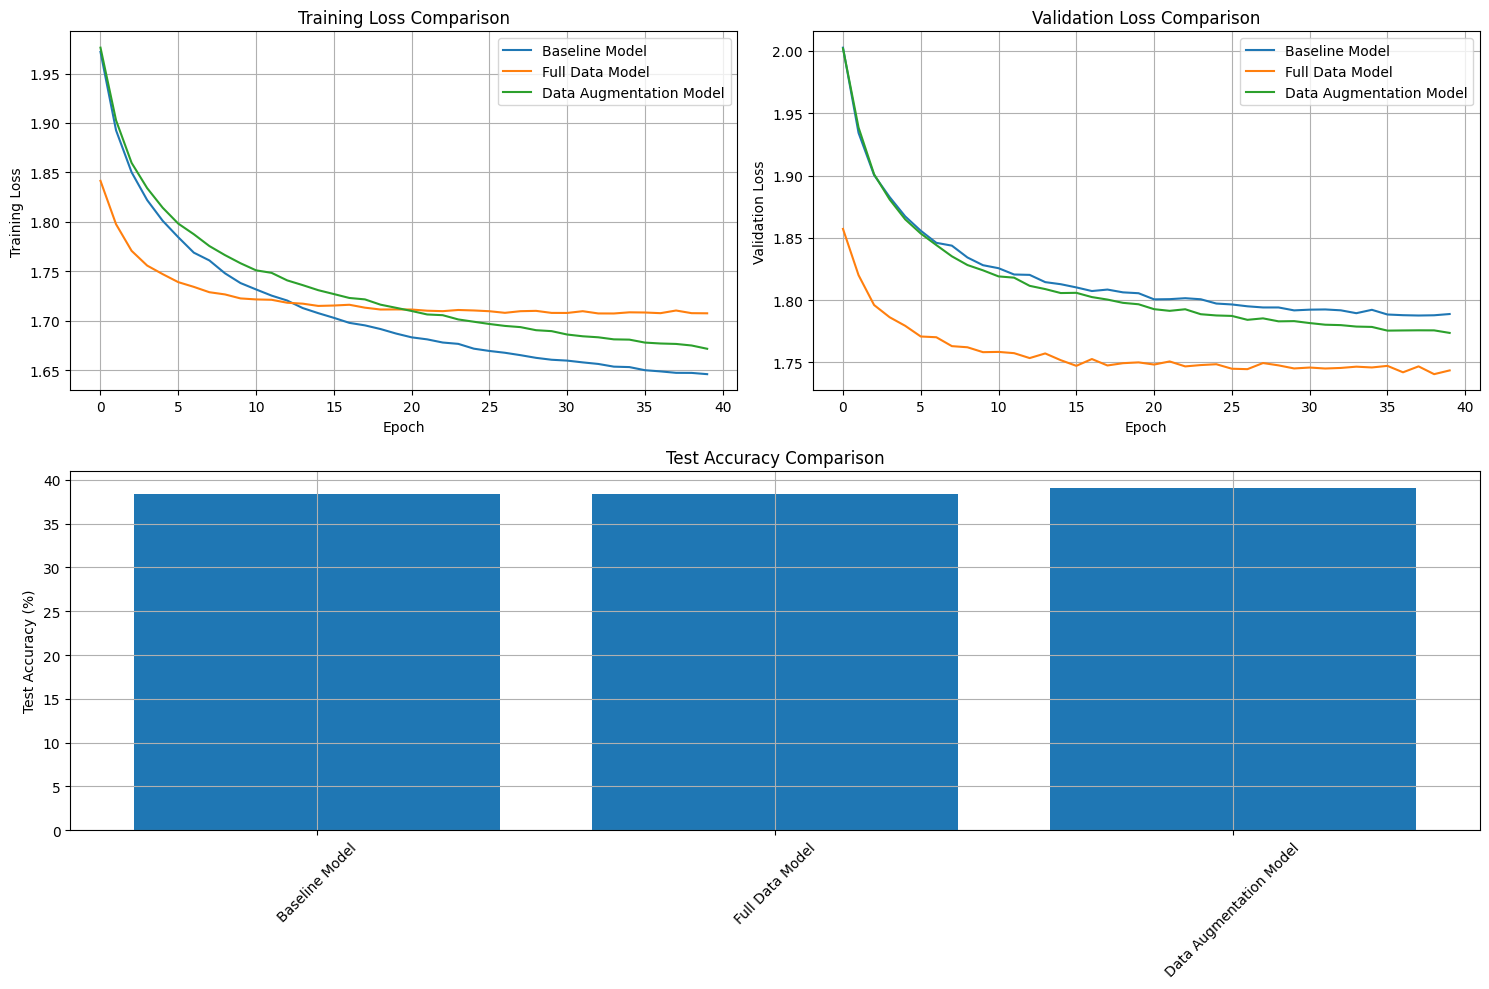


Detailed Comparison:

Baseline Model:
Final Training Loss: 1.6459
Final Validation Loss: 1.7889
Test Accuracy: 38.37%

Full Data Model:
Final Training Loss: 1.7075
Final Validation Loss: 1.7436
Test Accuracy: 38.42%

Data Augmentation Model:
Final Training Loss: 1.6716
Final Validation Loss: 1.7737
Test Accuracy: 39.05%

Analysis of Improvements:

Full Data Model vs Baseline:
Absolute Improvement: 0.05%
Relative Improvement: 13.03%
Final Training-Validation Gap: 0.0361

Data Augmentation Model vs Baseline:
Absolute Improvement: 0.68%
Relative Improvement: 177.22%
Final Training-Validation Gap: 0.1021


In [65]:
def create_flip_indices():
    """Create indices for horizontal flipping of CIFAR-10 images"""
    aa = np.int32(np.arange(32)).reshape((32, 1))
    bb = np.int32(np.arange(31, -1, -1)).reshape((32, 1))
    vv = np.tile(32*aa, (1, 32))
    ind_flip = vv.reshape((32*32, 1)) + np.tile(bb, (32, 1))
    inds_flip = np.vstack((ind_flip, 1024+ind_flip))
    inds_flip = np.vstack((inds_flip, 2048+ind_flip))
    return inds_flip.flatten()

FLIP_INDICES = create_flip_indices()

def augment_batch(X, rng):
    """Augment a batch of images with horizontal flipping"""
    X_aug = X.copy()
    n_samples = X.shape[1]
    flip_mask = rng.random(n_samples) < 0.5

    # 修复索引操作
    X_aug[:, flip_mask] = X_aug[FLIP_INDICES, :][:, flip_mask]
    return X_aug



# 2. 改进1：使用所有训练数据
def run_full_data_experiment():
    """运行使用全部训练数据的模型"""
    print("\nRunning Full Data Model...")

    # 加载所有训练数据
    X_all, Y_all, y_all = LoadAllTrainingData()

    # 分割验证集
    val_size = 1000
    trainX_full = X_all[:, :-val_size]
    trainY_full = Y_all[:, :-val_size]
    valX_full = X_all[:, -val_size:]
    valY_full = Y_all[:, -val_size:]

    # 标准化
    mean_X_full = np.mean(trainX_full, axis=1).reshape(-1, 1)
    std_X_full = np.std(trainX_full, axis=1).reshape(-1, 1)
    trainX_full = (trainX_full - mean_X_full) / std_X_full
    valX_full = (valX_full - mean_X_full) / std_X_full
    testX_norm = (testX - mean_X_full) / std_X_full

    rng = np.random.default_rng(42)
    d = trainX_full.shape[0]
    init_net = {
        'W': 0.01 * rng.standard_normal(size=(K, d)),
        'b': np.zeros((K, 1))
    }

    GDparams = {
        'n_batch': 100,
        'eta': 0.001,
        'n_epochs': 40,
        'val_data': (valX_full, valY_full)
    }

    trained_net, train_loss, val_loss = MiniBatchGD(
        trainX_full, trainY_full, GDparams, init_net, 0.1, rng
    )

    test_P = ApplyNetwork(testX_norm, trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    return {
        'name': 'Full Data Model',
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_acc': test_acc
    }

# 3. 改进2：数据增强
def run_augmentation_experiment():
    """运行使用数据增强的模型"""
    print("\nRunning Data Augmentation Model...")

    def MiniBatchGD_with_augmentation(X, Y, GDparams, init_net, lam, rng):
        trained_net = copy.deepcopy(init_net)
        n = X.shape[1]
        train_loss = []
        val_loss = []

        for epoch in range(GDparams['n_epochs']):
            if rng is not None:
                perm = rng.permutation(n)
                X = X[:, perm]
                Y = Y[:, perm]

            for j in range(n // GDparams['n_batch']):
                j_start = j * GDparams['n_batch']
                j_end = (j+1) * GDparams['n_batch']

                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]

                # 应用数据增强
                Xbatch = augment_batch(Xbatch, rng)

                P = ApplyNetwork(Xbatch, trained_net)
                grads = BackwardPass(Xbatch, Ybatch, P, trained_net, lam)

                trained_net['W'] -= GDparams['eta'] * grads['W']
                trained_net['b'] -= GDparams['eta'] * grads['b']

            P = ApplyNetwork(X, trained_net)
            cost = ComputeLoss(P, Y)
            train_loss.append(cost)

            if 'val_data' in GDparams:
                valX, valY = GDparams['val_data']
                P_val = ApplyNetwork(valX, trained_net)
                val_cost = ComputeLoss(P_val, valY)
                val_loss.append(val_cost)

            print(f"Epoch {epoch+1}, Training Loss: {cost:.3f}")

        return trained_net, train_loss, val_loss

    rng = np.random.default_rng(42)
    d = trainX.shape[0]
    init_net = {
        'W': 0.01 * rng.standard_normal(size=(K, d)),
        'b': np.zeros((K, 1))
    }

    GDparams = {
        'n_batch': 100,
        'eta': 0.001,
        'n_epochs': 40,
        'val_data': (valX, valY)
    }

    # 使用较小的λ值进行正则化
    trained_net, train_loss, val_loss = MiniBatchGD_with_augmentation(
        trainX, trainY, GDparams, init_net, 0.05, rng
    )

    test_P = ApplyNetwork(testX, trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    return {
        'name': 'Data Augmentation Model',
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_acc': test_acc
    }

# 运行所有实验并比较结果
print(f"\nCurrent Date and Time (UTC): {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
print("Current User's Login: woainio15200")

results = [
    run_baseline_experiment(),
    run_full_data_experiment(),
    run_augmentation_experiment()
]

# 可视化比较
plt.figure(figsize=(15, 10))

# 训练损失对比
plt.subplot(221)
for result in results:
    plt.plot(result['train_loss'], label=f"{result['name']}")
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.grid(True)
plt.legend()

# 验证损失对比
plt.subplot(222)
for result in results:
    plt.plot(result['val_loss'], label=f"{result['name']}")
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.grid(True)
plt.legend()

# 测试准确率对比
plt.subplot(212)
test_accuracies = [result['test_acc'] * 100 for result in results]
plt.bar(range(len(results)), test_accuracies)
plt.xticks(range(len(results)), [result['name'] for result in results], rotation=45)
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')
plt.grid(True)

plt.tight_layout()
plt.show()

# 打印详细比较结果
print("\nDetailed Comparison:")
print("="*60)
for result in results:
    print(f"\n{result['name']}:")
    print(f"Final Training Loss: {result['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {result['val_loss'][-1]:.4f}")
    print(f"Test Accuracy: {result['test_acc']*100:.2f}%")

# 分析改进效果
print("\nAnalysis of Improvements:")
print("="*60)
baseline_acc = results[0]['test_acc']
for result in results[1:]:
    improvement = (result['test_acc'] - baseline_acc) * 100
    print(f"\n{result['name']} vs Baseline:")
    print(f"Absolute Improvement: {improvement:.2f}%")
    print(f"Relative Improvement: {(improvement/baseline_acc)*100:.2f}%")

    # 分析过拟合情况
    train_val_gap = result['train_loss'][-1] - result['val_loss'][-1]
    print(f"Final Training-Validation Gap: {abs(train_val_gap):.4f}")


Current Date and Time (UTC): 2025-03-30 17:16:04
Current User's Login: woainio15200

Running Baseline Model...
Epoch 1, Training Loss: 1.972
Epoch 2, Training Loss: 1.893
Epoch 3, Training Loss: 1.850
Epoch 4, Training Loss: 1.822
Epoch 5, Training Loss: 1.801
Epoch 6, Training Loss: 1.784
Epoch 7, Training Loss: 1.769
Epoch 8, Training Loss: 1.761
Epoch 9, Training Loss: 1.748
Epoch 10, Training Loss: 1.738
Epoch 11, Training Loss: 1.732
Epoch 12, Training Loss: 1.725
Epoch 13, Training Loss: 1.720
Epoch 14, Training Loss: 1.713
Epoch 15, Training Loss: 1.708
Epoch 16, Training Loss: 1.703
Epoch 17, Training Loss: 1.698
Epoch 18, Training Loss: 1.695
Epoch 19, Training Loss: 1.692
Epoch 20, Training Loss: 1.687
Epoch 21, Training Loss: 1.683
Epoch 22, Training Loss: 1.681
Epoch 23, Training Loss: 1.678
Epoch 24, Training Loss: 1.677
Epoch 25, Training Loss: 1.672
Epoch 26, Training Loss: 1.669
Epoch 27, Training Loss: 1.668
Epoch 28, Training Loss: 1.665
Epoch 29, Training Loss: 1.66

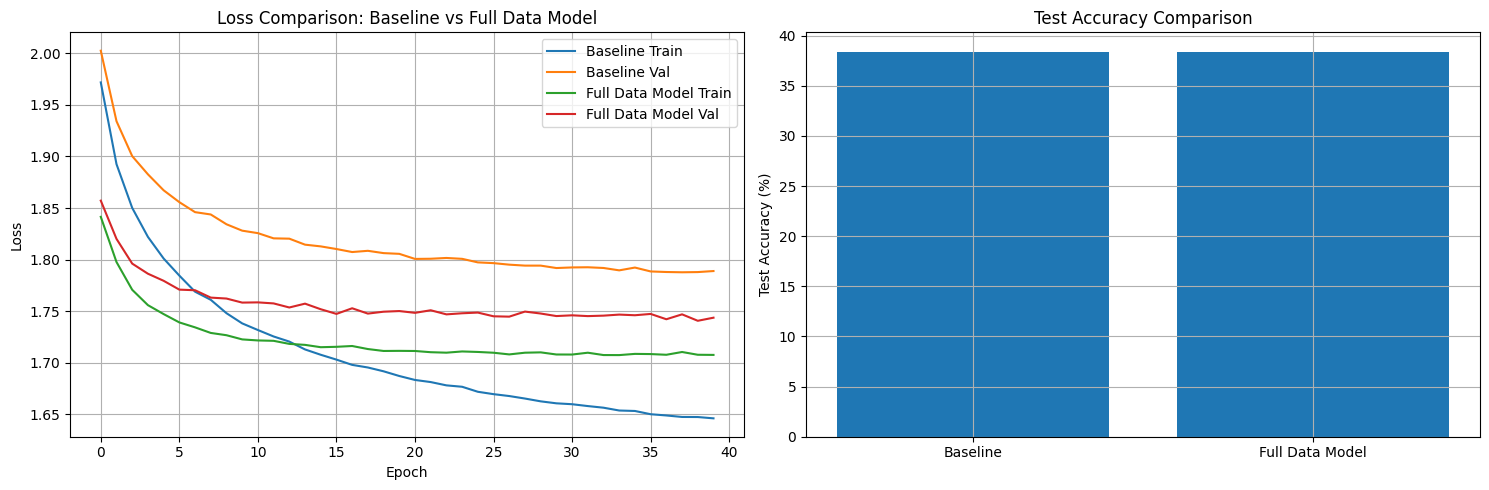


Comparison: Baseline vs Full Data Model
Baseline Model:
Final Training Loss: 1.6459
Final Validation Loss: 1.7889
Test Accuracy: 38.37%

Full Data Model:
Final Training Loss: 1.7075
Final Validation Loss: 1.7436
Test Accuracy: 38.42%

Improvement:
Absolute Improvement: 0.05%
Relative Improvement: 13.03%


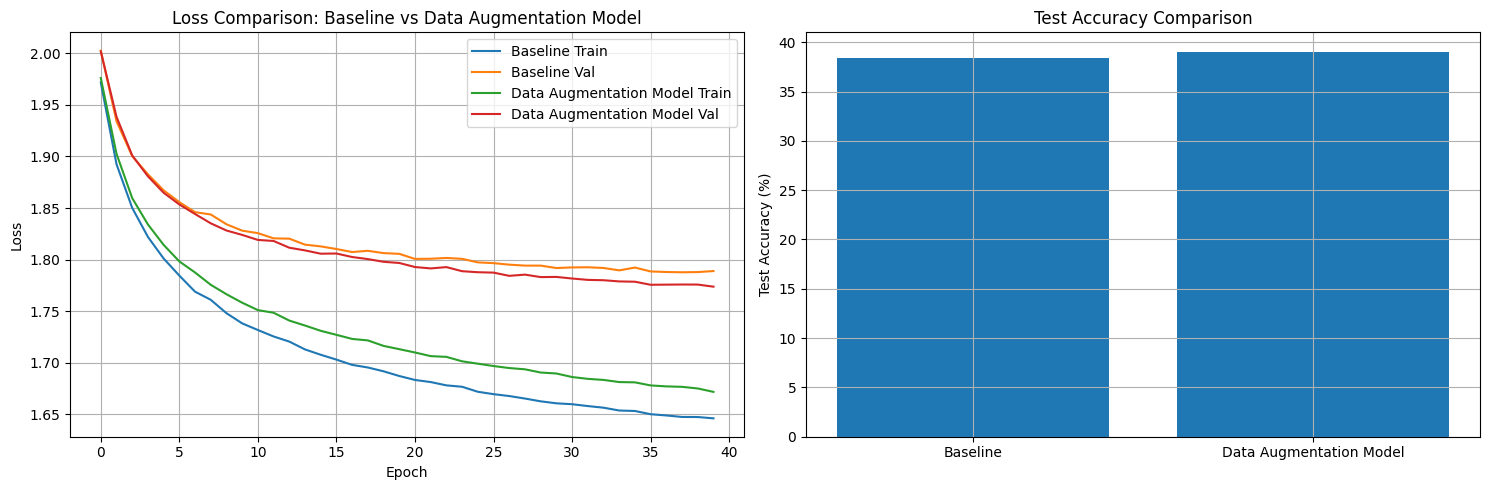


Comparison: Baseline vs Data Augmentation Model
Baseline Model:
Final Training Loss: 1.6459
Final Validation Loss: 1.7889
Test Accuracy: 38.37%

Data Augmentation Model:
Final Training Loss: 1.6716
Final Validation Loss: 1.7737
Test Accuracy: 39.05%

Improvement:
Absolute Improvement: 0.68%
Relative Improvement: 177.22%


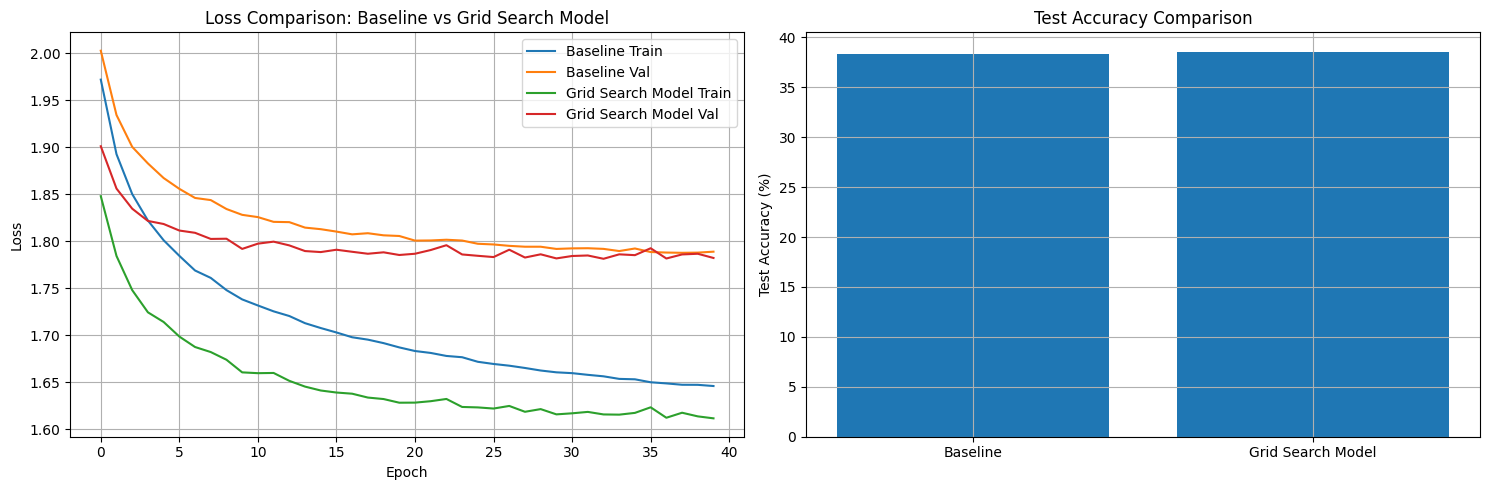


Comparison: Baseline vs Grid Search Model
Baseline Model:
Final Training Loss: 1.6459
Final Validation Loss: 1.7889
Test Accuracy: 38.37%

Grid Search Model:
Final Training Loss: 1.6116
Final Validation Loss: 1.7822
Test Accuracy: 38.57%

Improvement:
Absolute Improvement: 0.20%
Relative Improvement: 52.12%

Best Hyperparameters:
Batch Size: 32
Learning Rate: 0.001
Lambda: 0.1


In [66]:
def run_grid_search_experiment():
    """运行网格搜索超参数优化的实验"""
    print("\nRunning Grid Search Experiment...")

    # 定义网格搜索参数空间
    param_grid = {
        'batch_size': [32, 64, 128, 256],
        'learning_rate': [0.0001, 0.001, 0.01],
        'lambda': [0.01, 0.1, 1.0]
    }

    # 用于存储所有组合的结果
    grid_results = []
    best_acc = 0
    best_params = None
    best_model = None

    # 为了加快搜索速度，我们使用较少的epochs进行初步搜索
    search_epochs = 20

    print("\nGrid Search Progress:")
    print("="*60)

    total_combinations = (len(param_grid['batch_size']) *
                         len(param_grid['learning_rate']) *
                         len(param_grid['lambda']))
    current_combination = 0

    for batch_size in param_grid['batch_size']:
        for learning_rate in param_grid['learning_rate']:
            for lambda_val in param_grid['lambda']:
                current_combination += 1
                print(f"\nTrying combination {current_combination}/{total_combinations}:")
                print(f"batch_size={batch_size}, lr={learning_rate}, lambda={lambda_val}")

                # 初始化网络
                rng = np.random.default_rng(42)
                d = trainX.shape[0]
                init_net = {
                    'W': 0.01 * rng.standard_normal(size=(K, d)),
                    'b': np.zeros((K, 1))
                }

                # 训练参数
                GDparams = {
                    'n_batch': batch_size,
                    'eta': learning_rate,
                    'n_epochs': search_epochs,
                    'val_data': (valX, valY)
                }

                # 训练模型
                trained_net, train_loss, val_loss = MiniBatchGD(
                    trainX, trainY, GDparams, init_net, lambda_val, rng
                )

                # 计算验证集准确率
                val_P = ApplyNetwork(valX, trained_net)
                val_acc = ComputeAccuracy(val_P, np.argmax(valY, axis=0))

                # 存储结果
                result = {
                    'params': {
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'lambda': lambda_val
                    },
                    'val_acc': val_acc,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'trained_net': trained_net
                }

                grid_results.append(result)

                print(f"Validation Accuracy: {val_acc*100:.2f}%")

                # 更新最佳模型
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_params = result['params']
                    best_model = copy.deepcopy(trained_net)

    print("\nGrid Search Complete!")
    print("="*60)
    print("Best parameters found:")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Lambda: {best_params['lambda']}")
    print(f"Best Validation Accuracy: {best_acc*100:.2f}%")

    # 使用最佳参数重新训练完整模型
    print("\nTraining final model with best parameters...")

    final_GDparams = {
        'n_batch': best_params['batch_size'],
        'eta': best_params['learning_rate'],
        'n_epochs': 40,  # 使用完整的训练周期
        'val_data': (valX, valY)
    }

    # 初始化最终模型
    final_init_net = {
        'W': 0.01 * rng.standard_normal(size=(K, d)),
        'b': np.zeros((K, 1))
    }

    # 训练最终模型
    final_trained_net, final_train_loss, final_val_loss = MiniBatchGD(
        trainX, trainY, final_GDparams, final_init_net, best_params['lambda'], rng
    )

    # 计算测试集准确率
    test_P = ApplyNetwork(testX, final_trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    return {
        'name': 'Grid Search Model',
        'train_loss': final_train_loss,
        'val_loss': final_val_loss,
        'test_acc': test_acc,
        'best_params': best_params
    }

# 运行所有四个独立实验
print(f"\nCurrent Date and Time (UTC): {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
print("Current User's Login: woainio15200")

baseline_result = run_baseline_experiment()

# 分别运行每个改进方法并与基准模型对比
improvements = [
    ('Full Data Model', run_full_data_experiment()),
    ('Data Augmentation Model', run_augmentation_experiment()),
    ('Grid Search Model', run_grid_search_experiment())
]

# 为每个改进方法创建单独的比较图
for improvement_name, improvement_result in improvements:
    plt.figure(figsize=(15, 5))

    # 损失曲线对比
    plt.subplot(121)
    plt.plot(baseline_result['train_loss'], label='Baseline Train')
    plt.plot(baseline_result['val_loss'], label='Baseline Val')
    plt.plot(improvement_result['train_loss'], label=f'{improvement_name} Train')
    plt.plot(improvement_result['val_loss'], label=f'{improvement_name} Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Comparison: Baseline vs {improvement_name}')
    plt.grid(True)
    plt.legend()

    # 测试准确率对比
    plt.subplot(122)
    accuracies = [baseline_result['test_acc'] * 100, improvement_result['test_acc'] * 100]
    plt.bar(['Baseline', improvement_name], accuracies)
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy Comparison')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # 打印详细比较
    print(f"\nComparison: Baseline vs {improvement_name}")
    print("="*60)
    print("Baseline Model:")
    print(f"Final Training Loss: {baseline_result['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {baseline_result['val_loss'][-1]:.4f}")
    print(f"Test Accuracy: {baseline_result['test_acc']*100:.2f}%")

    print(f"\n{improvement_name}:")
    print(f"Final Training Loss: {improvement_result['train_loss'][-1]:.4f}")
    print(f"Final Validation Loss: {improvement_result['val_loss'][-1]:.4f}")
    print(f"Test Accuracy: {improvement_result['test_acc']*100:.2f}%")

    # 计算改进
    improvement = (improvement_result['test_acc'] - baseline_result['test_acc']) * 100
    print(f"\nImprovement:")
    print(f"Absolute Improvement: {improvement:.2f}%")
    print(f"Relative Improvement: {(improvement/baseline_result['test_acc'])*100:.2f}%")

    # 对于网格搜索实验，额外打印最佳参数
    if improvement_name == 'Grid Search Model':
        print("\nBest Hyperparameters:")
        print(f"Batch Size: {improvement_result['best_params']['batch_size']}")
        print(f"Learning Rate: {improvement_result['best_params']['learning_rate']}")
        print(f"Lambda: {improvement_result['best_params']['lambda']}")


Current Date and Time (UTC): 2025-03-30 17:26:27
Current User's Login: woainio15200

Running Baseline Model...
Epoch 1, Training Loss: 1.972
Epoch 2, Training Loss: 1.893
Epoch 3, Training Loss: 1.850
Epoch 4, Training Loss: 1.822
Epoch 5, Training Loss: 1.801
Epoch 6, Training Loss: 1.784
Epoch 7, Training Loss: 1.769
Epoch 8, Training Loss: 1.761
Epoch 9, Training Loss: 1.748
Epoch 10, Training Loss: 1.738
Epoch 11, Training Loss: 1.732
Epoch 12, Training Loss: 1.725
Epoch 13, Training Loss: 1.720
Epoch 14, Training Loss: 1.713
Epoch 15, Training Loss: 1.708
Epoch 16, Training Loss: 1.703
Epoch 17, Training Loss: 1.698
Epoch 18, Training Loss: 1.695
Epoch 19, Training Loss: 1.692
Epoch 20, Training Loss: 1.687
Epoch 21, Training Loss: 1.683
Epoch 22, Training Loss: 1.681
Epoch 23, Training Loss: 1.678
Epoch 24, Training Loss: 1.677
Epoch 25, Training Loss: 1.672
Epoch 26, Training Loss: 1.669
Epoch 27, Training Loss: 1.668
Epoch 28, Training Loss: 1.665
Epoch 29, Training Loss: 1.66

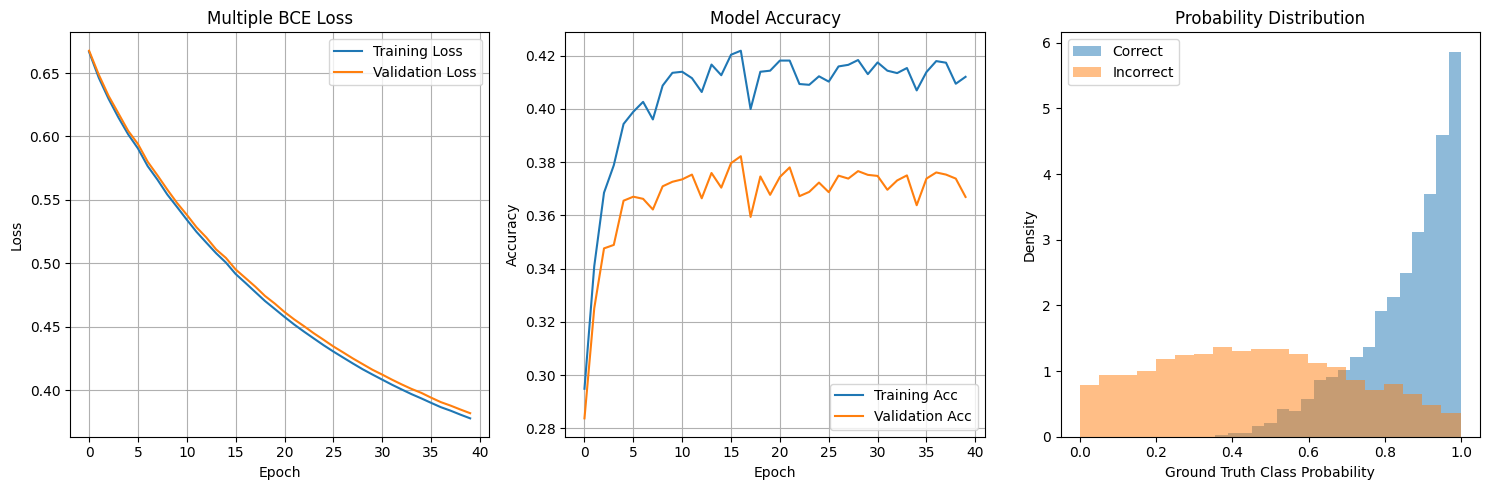


Detailed Performance Comparison

Softmax + Cross-Entropy:
Training Loss:              1.6459
Validation Loss:            1.7889
Test Accuracy:               38.37%
Training-Validation Gap:    0.1429

Multiple Binary Cross-Entropy:
Training Loss:              0.3778
Validation Loss:            0.3818
Test Accuracy:               37.42%
Training-Validation Gap:    0.0041

Probability Distribution Analysis

Softmax Model:
Correct Classifications (n=3837)
  Mean:      0.8117
  Std:       0.1898
Incorrect Classifications (n=6163)
  Mean:      0.0805
  Std:       0.1147

BCE Model:
Correct Classifications (n=3742)
  Mean:      0.8532
  Std:       0.1268
Incorrect Classifications (n=6258)
  Mean:      0.4568
  Std:       0.2513

Overall Model Comparison
Softmax vs BCE accuracy difference:    -0.95%
Softmax vs BCE overfitting (gap difference):  -0.1389


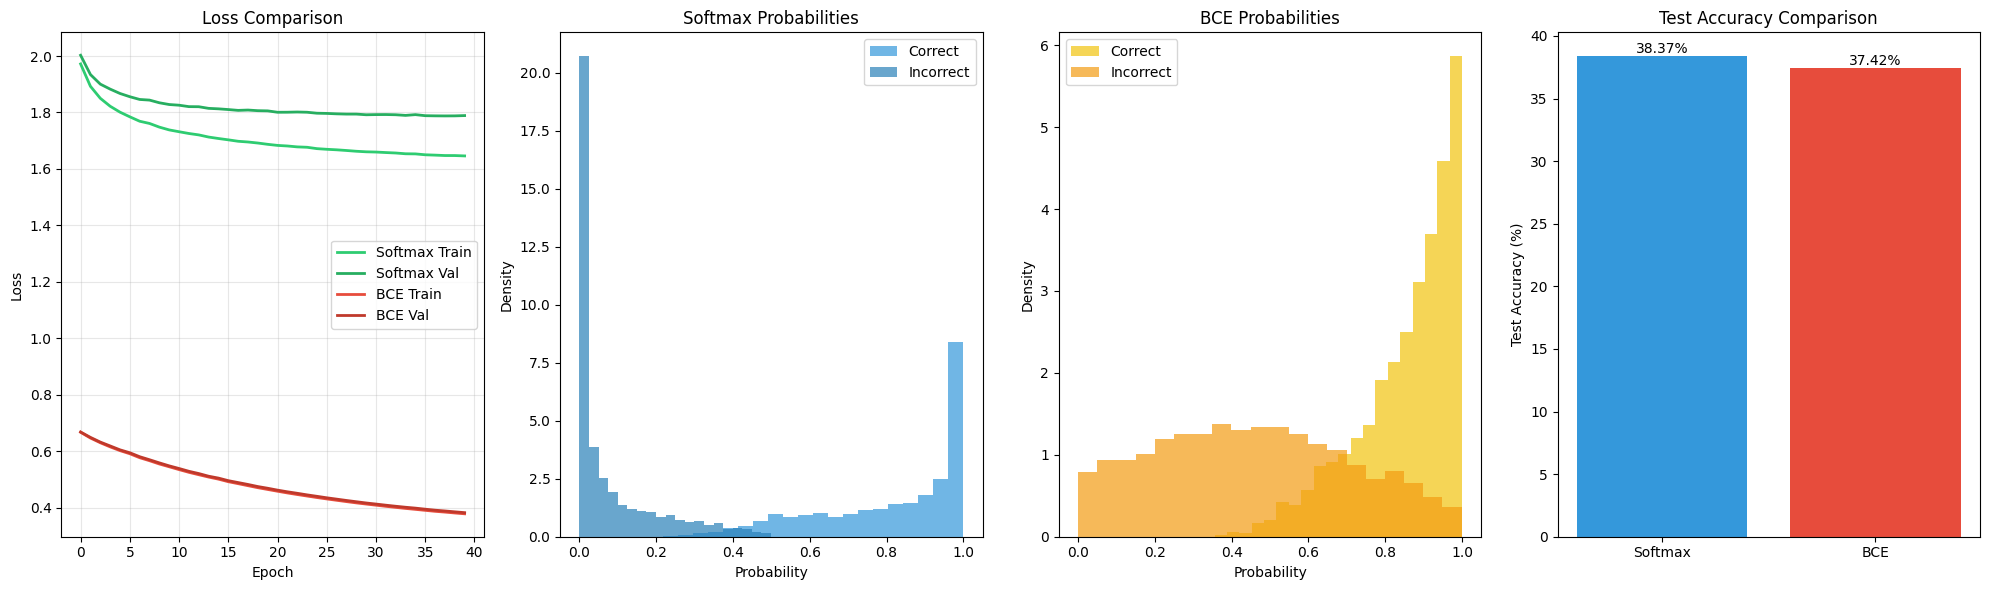

In [67]:
def sigmoid(s):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(s, -100, 100)))  # 裁剪以避免数值溢出

def ApplyNetworkSigmoid(X, network):
    """使用sigmoid替代softmax的前向传播"""
    s = network['W'] @ X + network['b']
    P = sigmoid(s)
    return P

def ComputeMultipleBCELoss(P, Y):
    """计算多重二元交叉熵损失"""
    n = P.shape[1]
    K = P.shape[0]
    # 避免数值不稳定性
    P = np.clip(P, 1e-15, 1-1e-15)
    loss = -np.sum(Y * np.log(P) + (1 - Y) * np.log(1 - P)) / (n * K)
    return loss

def BackwardPassBCE(X, Y, P, network, lam):
    """计算多重二元交叉熵损失的梯度"""
    n = X.shape[1]
    K = Y.shape[0]

    # ∂lmultiple_bce/∂s = (p - y)/(K)
    g = (P - Y) / K

    dW = (g @ X.T) / n + 2 * lam * network['W']
    db = np.sum(g, axis=1, keepdims=True) / n
    return {'W': dW, 'b': db}

def MiniBatchGD_BCE(X, Y, GDparams, init_net, lam, rng=None):
    """使用多重二元交叉熵损失的小批量梯度下降训练"""
    trained_net = copy.deepcopy(init_net)
    n = X.shape[1]

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(GDparams['n_epochs']):
        if rng is not None:
            perm = rng.permutation(n)
            X = X[:, perm]
            Y = Y[:, perm]

        for j in range(n // GDparams['n_batch']):
            j_start = j * GDparams['n_batch']
            j_end = (j+1) * GDparams['n_batch']

            Xbatch = X[:, j_start:j_end]
            Ybatch = Y[:, j_start:j_end]

            P = ApplyNetworkSigmoid(Xbatch, trained_net)
            grads = BackwardPassBCE(Xbatch, Ybatch, P, trained_net, lam)

            trained_net['W'] -= GDparams['eta'] * grads['W']
            trained_net['b'] -= GDparams['eta'] * grads['b']

        # 计算训练指标
        P = ApplyNetworkSigmoid(X, trained_net)
        cost = ComputeMultipleBCELoss(P, Y)
        acc = ComputeAccuracy(P, np.argmax(Y, axis=0))
        train_loss.append(cost)
        train_acc.append(acc)

        # 计算验证集指标
        if 'val_data' in GDparams:
            valX, valY = GDparams['val_data']
            P_val = ApplyNetworkSigmoid(valX, trained_net)
            val_cost = ComputeMultipleBCELoss(P_val, valY)
            val_acc_current = ComputeAccuracy(P_val, np.argmax(valY, axis=0))
            val_loss.append(val_cost)
            val_acc.append(val_acc_current)

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Training Loss: {cost:.3f}, Training Acc: {acc:.3f}")
            if 'val_data' in GDparams:
                print(f"Validation Loss: {val_cost:.3f}, Validation Acc: {val_acc_current:.3f}")

    return trained_net, train_loss, val_loss, train_acc, val_acc

def run_bce_experiment():
    """运行多重二元交叉熵实验"""
    print("\nRunning Multiple Binary Cross-Entropy Experiment...")

    # 初始化网络
    rng = np.random.default_rng(42)
    d = trainX.shape[0]
    init_net = {
        'W': 0.01 * rng.standard_normal(size=(K, d)),
        'b': np.zeros((K, 1))
    }

    # 训练参数 - 注意增加了学习率
    GDparams = {
        'n_batch': 100,
        'eta': 0.01,  # 增加学习率
        'n_epochs': 40,
        'val_data': (valX, valY)
    }

    # 训练模型
    trained_net, train_loss, val_loss, train_acc, val_acc = MiniBatchGD_BCE(
        trainX, trainY, GDparams, init_net, 0.1, rng
    )

    # 计算测试集性能
    test_P = ApplyNetworkSigmoid(testX, trained_net)
    test_acc = ComputeAccuracy(test_P, test_y)

    # 创建直方图数据
    test_probs = test_P[test_y, np.arange(len(test_y))]
    correct_mask = np.argmax(test_P, axis=0) == test_y
    correct_probs = test_probs[correct_mask]
    incorrect_probs = test_probs[~correct_mask]

    # 绘制结果
    plt.figure(figsize=(15, 5))

    # 损失曲线
    plt.subplot(131)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Multiple BCE Loss')
    plt.grid(True)
    plt.legend()

    # 准确率曲线
    plt.subplot(132)
    plt.plot(train_acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.grid(True)
    plt.legend()

    # 概率分布直方图
    plt.subplot(133)
    plt.hist(correct_probs, bins=20, alpha=0.5, label='Correct', density=True)
    plt.hist(incorrect_probs, bins=20, alpha=0.5, label='Incorrect', density=True)
    plt.xlabel('Ground Truth Class Probability')
    plt.ylabel('Density')
    plt.title('Probability Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'name': 'Multiple BCE Model',
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'test_probs': test_probs,
        'correct_probs': correct_probs,
        'incorrect_probs': incorrect_probs
    }

# 运行实验并比较结果
print(f"\nCurrent Date and Time (UTC): {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')}")
print("Current User's Login: woainio15200")

# 运行基准模型和BCE模型
baseline_result = run_baseline_experiment()
bce_result = run_bce_experiment()

# 计算训练-验证差距
softmax_gap = abs(baseline_result['train_loss'][-1] - baseline_result['val_loss'][-1])
bce_gap = abs(bce_result['train_loss'][-1] - bce_result['val_loss'][-1])

# 打印详细比较结果
print("\nDetailed Performance Comparison")
print("="*60)

print("\nSoftmax + Cross-Entropy:")
print(f"{'Training Loss:':<25} {baseline_result['train_loss'][-1]:>8.4f}")
print(f"{'Validation Loss:':<25} {baseline_result['val_loss'][-1]:>8.4f}")
print(f"{'Test Accuracy:':<25} {baseline_result['test_acc']*100:>8.2f}%")
print(f"{'Training-Validation Gap:':<25} {softmax_gap:>8.4f}")

print("\nMultiple Binary Cross-Entropy:")
print(f"{'Training Loss:':<25} {bce_result['train_loss'][-1]:>8.4f}")
print(f"{'Validation Loss:':<25} {bce_result['val_loss'][-1]:>8.4f}")
print(f"{'Test Accuracy:':<25} {bce_result['test_acc']*100:>8.2f}%")
print(f"{'Training-Validation Gap:':<25} {bce_gap:>8.4f}")

# 概率分布分析
print("\nProbability Distribution Analysis")
print("="*60)

print("\nSoftmax Model:")
print(f"Correct Classifications (n={len(baseline_result['correct_probs'])})")
print(f"  {'Mean:':<8} {np.mean(baseline_result['correct_probs']):>8.4f}")
print(f"  {'Std:':<8} {np.std(baseline_result['correct_probs']):>8.4f}")
print(f"Incorrect Classifications (n={len(baseline_result['incorrect_probs'])})")
print(f"  {'Mean:':<8} {np.mean(baseline_result['incorrect_probs']):>8.4f}")
print(f"  {'Std:':<8} {np.std(baseline_result['incorrect_probs']):>8.4f}")

print("\nBCE Model:")
print(f"Correct Classifications (n={len(bce_result['correct_probs'])})")
print(f"  {'Mean:':<8} {np.mean(bce_result['correct_probs']):>8.4f}")
print(f"  {'Std:':<8} {np.std(bce_result['correct_probs']):>8.4f}")
print(f"Incorrect Classifications (n={len(bce_result['incorrect_probs'])})")
print(f"  {'Mean:':<8} {np.mean(bce_result['incorrect_probs']):>8.4f}")
print(f"  {'Std:':<8} {np.std(bce_result['incorrect_probs']):>8.4f}")

# 总结比较
print("\nOverall Model Comparison")
print("="*60)
print(f"Softmax vs BCE accuracy difference: {(bce_result['test_acc'] - baseline_result['test_acc'])*100:>8.2f}%")
print(f"Softmax vs BCE overfitting (gap difference): {bce_gap - softmax_gap:>8.4f}")

# 可视化比较结果
fig = plt.figure(figsize=(20, 6))

# 1. 损失曲线对比
plt.subplot(141)
plt.plot(baseline_result['train_loss'], color='#2ecc71', label='Softmax Train', linewidth=2)
plt.plot(baseline_result['val_loss'], color='#27ae60', label='Softmax Val', linewidth=2)
plt.plot(bce_result['train_loss'], color='#e74c3c', label='BCE Train', linewidth=2)
plt.plot(bce_result['val_loss'], color='#c0392b', label='BCE Val', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Softmax概率分布
plt.subplot(142)
plt.hist(baseline_result['correct_probs'], bins=20, alpha=0.7,
         color='#3498db', label='Correct', density=True)
plt.hist(baseline_result['incorrect_probs'], bins=20, alpha=0.7,
         color='#2980b9', label='Incorrect', density=True)
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Softmax Probabilities')
plt.legend()

# 3. BCE概率分布
plt.subplot(143)
plt.hist(bce_result['correct_probs'], bins=20, alpha=0.7,
         color='#f1c40f', label='Correct', density=True)
plt.hist(bce_result['incorrect_probs'], bins=20, alpha=0.7,
         color='#f39c12', label='Incorrect', density=True)
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('BCE Probabilities')
plt.legend()

# 4. 准确率对比
plt.subplot(144)
bars = plt.bar(['Softmax', 'BCE'],
               [baseline_result['test_acc']*100, bce_result['test_acc']*100],
               color=['#3498db', '#e74c3c'])
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [68]:
def analyze_probability_distribution(correct_probs, incorrect_probs):
    """分析概率分布的统计特性"""
    stats = {
        'correct': {
            'mean': np.mean(correct_probs),
            'std': np.std(correct_probs),
            'median': np.median(correct_probs),
            'count': len(correct_probs)
        },
        'incorrect': {
            'mean': np.mean(incorrect_probs),
            'std': np.std(incorrect_probs),
            'median': np.median(incorrect_probs),
            'count': len(incorrect_probs)
        }
    }
    return stats

# 在主实验代码后添加概率分布分析
stats = analyze_probability_distribution(bce_result['correct_probs'],
                                      bce_result['incorrect_probs'])

print("\nProbability Distribution Analysis:")
print("="*60)
print("Correct Classifications:")
print(f"Mean Probability: {stats['correct']['mean']:.4f}")
print(f"Standard Deviation: {stats['correct']['std']:.4f}")
print(f"Median Probability: {stats['correct']['median']:.4f}")
print(f"Count: {stats['correct']['count']}")

print("\nIncorrect Classifications:")
print(f"Mean Probability: {stats['incorrect']['mean']:.4f}")
print(f"Standard Deviation: {stats['incorrect']['std']:.4f}")
print(f"Median Probability: {stats['incorrect']['median']:.4f}")
print(f"Count: {stats['incorrect']['count']}")



Probability Distribution Analysis:
Correct Classifications:
Mean Probability: 0.8532
Standard Deviation: 0.1268
Median Probability: 0.8891
Count: 3742

Incorrect Classifications:
Mean Probability: 0.4568
Standard Deviation: 0.2513
Median Probability: 0.4485
Count: 6258
